# <center>Practical 11: Articulated Robots - Dynamics</center>

## Update the Robotics Toolbox

### In your local machine (Windows)

1. Open File Explorer and go to the folder in which you cloned the Practicals repository
3. Using the right click, select ``Git Bash Here``
4. Type ``git submodule update --remote --merge``
5. Open Anaconda prompt
6. Type ``cd Week10/Support/robotics-toolbox-python``
7. Type ``pip3 install -e . ``
8. On your browser, open Practical11_Dynamics and restart the kernel

### In AWS
1. Open a new terminal
2. Type ``cd SageMaker/ECE4078_Practicals/ && git submodule update --remote --merge``
3. Inside your notebook, execute
    ```python 
    %cd ../Week10/Support/robotics-toolbox-python
    %env CFLAGS='-std=c99'
    import sys
    !{sys.executable} -m pip install -e .
    %cd ../../../Week11```
4. Restart the kernel

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
%matplotlib notebook

import roboticstoolbox as rtb
from roboticstoolbox import DHRobot, RevoluteDH
from spatialmath import SE3, SO3

import time
import sys
import os
sys.path.insert(0, os.path.abspath('Support'))

from visualizer import *

# Dynamics 3-dof Manipulator

Recall the 3-dof manipulator we saw in the last lecture

<img src="Support/images/3dof-linkrobot2.png" width="400" height="400" align="center">


This manipulator consists of 3 revolute joints with attributes

|$\theta_j$	| $d_j$ |   $a_j$	|  $\alpha_j$|
|---	|---	|---	|---	|
| $q_1$	|  1	|  0	|  $\pi/2$ |
| $q_2$ |  0 	|  1	| None 	|
| $q_3$ |  0	|  1	| None	|

where $d_j$ is the link offset, $a_j$ is the link length and $\alpha_j$ corresponds to the link twist

We extend the definition of each link and include the rigid-body inertial parameters, and motor and transmission parameters. These parameters are:
-  ``m``: link mass
- ``r``: position of center of mass (COM) with respect to link frame
- ``I``: inertia of link with respect to COM
- ``Jm``: motor inertia
- ``B``: motor viscous friction
- ``G``: gear ratio

### 1. Define Robot Links

In [2]:
link1 = RevoluteDH(d=1.0, a=0, alpha=np.pi/2, m=0,
                  r=np.zeros(3), Jm=200e-6, G=60, B=1.38e-3,
                  I=[0, 0.35, 0, 0, 0, 0])


link2 = RevoluteDH(d=0, a=1.0, alpha=0, m=17.4,
                  r=np.array([-0.3638, 0.006, 0.2275]), Jm=200e-6,
                  G=100, B=1.38e-3, I=[0.13, 0.524, 0.539, 0, 0, 0])

link3 = RevoluteDH(d=0, a=1.0, alpha=0, m=4.8,
                  r=np.array([-0.0203, -0.0141, 0.070]), Jm=200e-6,
                  G=50, B=1.38e-3,
                  I=[0.066, 0.086, 0.0125, 0, 0, 0])

my_bot = DHRobot([link1, link2, link3], name='3dof-manipulator')

Let's define some useful joint configurations and take a look at the parameters of our robot

In [3]:
# Add some useful configurations
my_bot.qz = np.array([0,0,0]) # zero angles
my_bot.qr = np.array([0, np.pi/2, 0]) # ready pose, arm up
my_bot.qs = np.array([0, 0, np.pi/2]) # straight and elbow up

# Print the kinematic & dynamic parameters
my_bot.printdyn()


Link 0:: Revolute   theta=q1 + 0.00,  d= 1.00,  a= 0.00,  alpha= 1.57
  m     =         0 
  r     =         0        0        0 
          |        0        0        0 | 
  I     = |        0     0.35        0 | 
          |        0        0        0 | 
  Jm    =    0.0002 
  B     =    0.0014 
  Tc    =         0(+)        0(-) 
  G     =        60 
  qlim  =         0 to        0

Link 1:: Revolute   theta=q2 + 0.00,  d= 0.00,  a= 1.00,  alpha= 0.00
  m     =        17 
  r     =     -0.36    0.006     0.23 
          |     0.13        0        0 | 
  I     = |        0     0.52        0 | 
          |        0        0     0.54 | 
  Jm    =    0.0002 
  B     =    0.0014 
  Tc    =         0(+)        0(-) 
  G     =     1e+02 
  qlim  =         0 to        0

Link 2:: Revolute   theta=q3 + 0.00,  d= 0.00,  a= 1.00,  alpha= 0.00
  m     =       4.8 
  r     =     -0.02   -0.014     0.07 
          |    0.066        0        0 | 
  I     = |        0    0.086        0 | 
         

### 2. Simulate Dynamics with Zero Torque Input

To simulate the robot's state with a given torque input, we apply these steps:
1. Compute joint acceleration ``qdd`` using forward dynamics
2. We integrate the computed joint acceleration and update the joint velocities ``dq``
3. We integrate current joint velocity ``qd`` and update the joint angles ``q``

In [4]:
# Set default configuration
my_bot.q = my_bot.qz
my_bot.qd = np.zeros(3)
my_bot.qdd = np.zeros(3)

# Number of iterations control loop
max_iterations = 200

# Time step
dt=0.05

# Variable needed for plotting
robot_state = {'q': [], 'qd': []}

# This is our control loop. Currently we call our controller for 1 second
for i in range(max_iterations):
        
    # Set all torques to zero
    tau = np.zeros(3)
        
    # Compute acceleration
    new_qdd = my_bot.accel(my_bot.q, my_bot.qd, tau)
    
    # Compute new state
    new_qd = my_bot.qd + new_qdd * dt
    new_q = my_bot.q + new_qd * dt
        
    # Assign new state to robot
    my_bot.q = new_q
    my_bot.qd = new_qd
    my_bot.qdd = new_qdd
    
    robot_state["q"].append(my_bot.q)
    robot_state["qd"].append(my_bot.qd)

### 2.1 Plot Robot's Trajectory

<IPython.core.display.Javascript object>


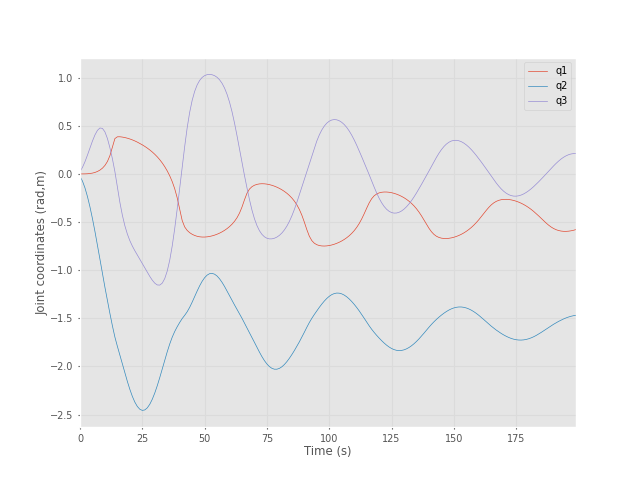

In [5]:
# Show the joint angle trajectory
rtb.tools.trajectory.qplot(np.array(robot_state["q"]))

### 2.3 Observe Robot Behaviour with Zero Torque

<IPython.core.display.Javascript object>


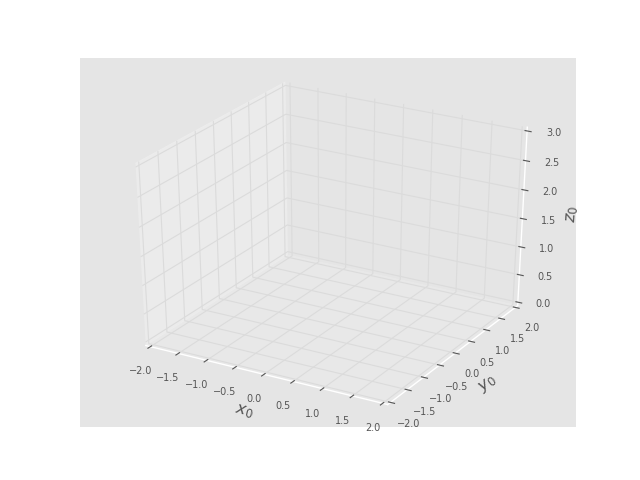

In [6]:
# Create visualization context
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)
ax.set_zlabel(r'$z_0$', fontsize=12)

# Create visualizer instance
my_plot = RobotJupyterPlot(my_bot, ax, readonly=True)

# Get trajectory to plot
path_to_plot = np.array(robot_state["q"])

def init():
    my_plot.draw()
    return

def animate(i):
    if i < len(path_to_plot):
        my_bot.q = path_to_plot[i]
        my_plot.draw()
    return
    
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=100, init_func=init,
                              repeat=False)

## 3. PD Controller

How can we make our robot hold a desired configuration? Let's define a PD controller for each joint and use it to compute the required torque.

To determine the proportional and derivative gains $K_p$ and $K_d$ for each joint we have added a helper function shown below

In [7]:
def define_pd_gains(my_bot, w=100.0):
    """
    Compute proportional and derivative gains for each joint controller
    :param my_bot (DHRobot): Robot for which gains will be computed
    :param w (float): Base coefficient for the computation of the gains
    :return tuple of np.arrays: Proportional and derivate gains for each joint in my_bot
    """
    K_p = []
    K_d = []
    
    for i in range(my_bot.n):
        Kp_i = w * w * my_bot.links[i].Jm
        Kd_i = 2 * w * my_bot.links[i].Jm - my_bot.links[i].B
        
        K_p.append(Kp_i)
        K_d.append(Kd_i)

    return np.array(K_p), np.array(K_d)

### 3.1 Define our PD Controller

This code is based on our PID implementation from Week 07

In [8]:
class PD(object):
    
    """A simple PD controller."""

    def __init__(self, desired_state=None, K_p=None, 
                 K_d=None):
        
        """
        Initialize a new PD controller.
        :param desired_q: Desired robot states (q, dq)
        :param K_p: The value for the proportional gain K_p
        :param K_d: The value for the derivative gain K_d
        """        
        if desired_state is None:
            desired_state = np.zeros(self.system.n)
            
        if K_p is None:
            K_p = np.ones(self.system.n) * 10
                        
        if K_d is None:
            K_d = np.ones(self.system.n) * 0.5
        
        self.set_point = desired_state
        self.K_p = K_p
        self.K_d = K_d
                
    
    def __compute_error__(self, system):
        """
        This method computes error between the robot's current and desired states
        :param system (DHRobot): Robot to control
        :return 1xn float array: joint and velocity error
        """
        return self.set_point - np.r_[system.q, system.qd]
    
    
    def compute_control(self, system):
        
        """
        This method computes the next control signal u_t so as to reduce the error
        between the robot's current state and the desired state (self.set_point)
        :param system (DHRobot): Robot to control
        :return 1xn float array: Torque input to apply to robot
        """
        
        # Compute error
        error_t = self.__compute_error__(system)
        
        # Compute new control
        new_control = self.K_p * error_t[:system.n] + self.K_d * error_t[system.n:]
                            
        return new_control

### 3.2 Run and Apply Controller

In [9]:
# Define desired state. We want the robot to be on the ready state, arm up with zero velocity
desired_state = np.r_[my_bot.qr, np.zeros(my_bot.n)]

# Set initial robot state
my_bot.q = my_bot.qz
my_bot.qd = np.zeros(3)
my_bot.qdd = np.zeros(3)

# Define time step
dt = 0.05

# Compute gain
K_p, K_d = define_pd_gains(my_bot, w=100)

# Create a PID controller
pd_control = PD(desired_state=desired_state, K_p=K_p, K_d=K_d)

# Variables needed for plotting
robot_state = {'q': [], 'qd': []}

# Number of iterations control loop
max_iterations = 200

# This is our control loop. Currently we call our controller for 1 second
for i in range(max_iterations):
        
    # Call controller to get new control signal
    tau = pd_control.compute_control(my_bot)
    
    # Compute acceleration
    new_qdd = my_bot.accel(my_bot.q, my_bot.qd, tau)
    
    # Compute new state
    new_qd = my_bot.qd + new_qdd * dt
    new_q = my_bot.q + new_qd * dt
        
    # Assign new state to robot
    my_bot.q = new_q
    my_bot.qd = new_qd
    my_bot.qdd = new_qdd
    
    robot_state["q"].append(my_bot.q)
    robot_state["qd"].append(my_bot.qd)

### 3.3 Plot Robot's Trajectory

<IPython.core.display.Javascript object>


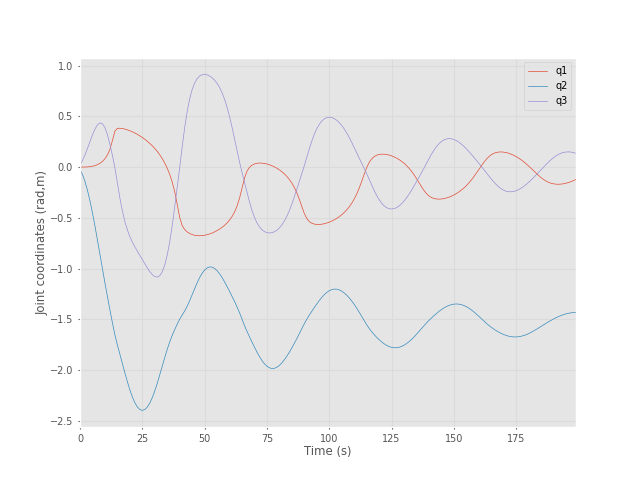

In [10]:
rtb.tools.trajectory.qplot(np.array(robot_state["q"]))

### 3.4 Observe Robot's Behaviour

<IPython.core.display.Javascript object>


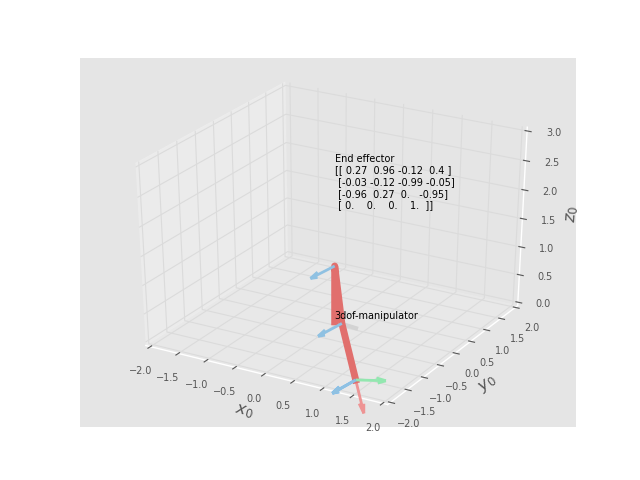

In [12]:
# Create visualization context
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-2.0, 2.0)
ax.set_ylim3d(-2.0, 2.0)
ax.set_zlim3d(0.0, 3.0)
ax.set_xlabel(r'$x_0$', fontsize=12)
ax.set_ylabel(r'$y_0$', fontsize=12)
ax.set_zlabel(r'$z_0$', fontsize=12)

# Create visualizer instance
my_plot = RobotJupyterPlot(my_bot, ax, readonly=True)

# Get trajectory to plot
path_to_plot = np.array(robot_state["q"])

def init():
    my_plot.draw()
    return

def animate(i):
    if i < len(path_to_plot):
        my_bot.q = path_to_plot[i]
        my_plot.draw()
    return
    
ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=100, init_func=init,
                              repeat=False)